In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d

# uncomment for inline matlab style interactive figures
# %matplotlib widget

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import calculate_snr
from fig_setup import fig_setup

fig_setup() # comment this if using matplotlib widget because they conflict

#### Useful parameters

In [2]:
# Parameters
save_figs = False

mod_freq = 60 # MHz
wavelength = 940 # nm
calib_offset = 624.5 # mm
cropX = 0
cropY = 0
gauss_dim = '1d'
phase_variation_axis="x"

unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2.0 * pi)

k_values = [30, 360/11, 36, 40, 45, 48, 360/7, 60, 72, 80, 90, 360/3.5, 120, 360/2.9, 360/2.8, 360/2.7, 360/2.6, 144, 360/2.4, 360/2.3, 360/2.2, 360/2.1] #[12, 11, 10, 9, 8, 7.5, 7, 6, 5, 4.5, 4, 3, 2.5]
k_values2 = [30, 36, 360/7, 90, 360/3.5, 120, 360/2.6]
using_sigmas = np.linspace(0, 6.9, num=70)

#### Load data
EVK75027 raw depth data is in mm

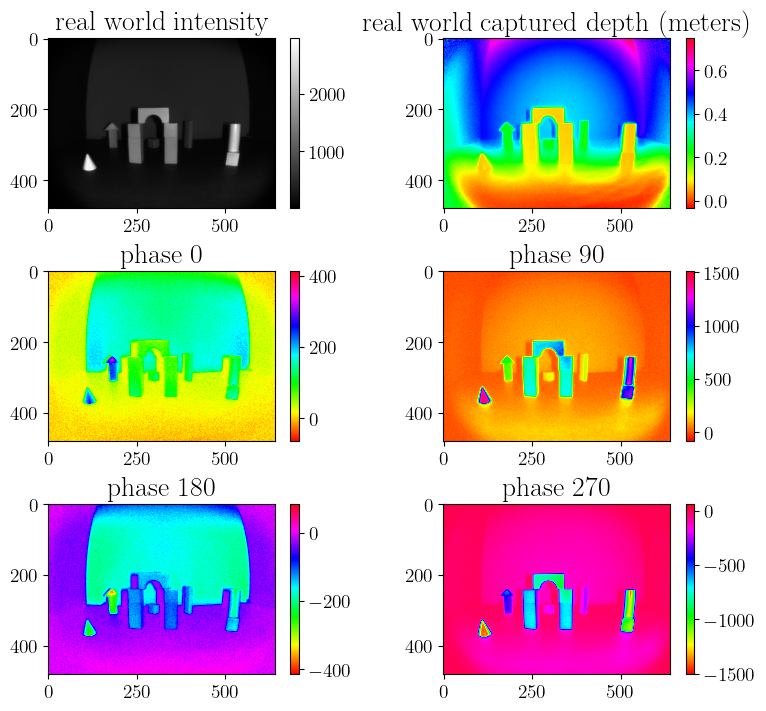

In [3]:
with np.load('data/emulation/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/emulation/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]
    
phase_rw = (depth_rw / coeff_to_rad) - pi # calculate the phase from the depth

# show the real world data
fig_rw, axs = plt.subplots(3,2, figsize=(8,7), layout="constrained")
im = axs[0,0].imshow(intensity_rw, cmap="gray")
axs[0,0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(depth_rw, cmap="hsv")
axs[0,1].set_title("real world captured depth (meters)")
fig_rw.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(I0_rw, cmap="hsv")
axs[1,0].set_title("phase 0")
fig_rw.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(I90_rw, cmap="hsv")
axs[1,1].set_title("phase 90")
fig_rw.colorbar(im, ax=axs[1,1])

im = axs[2,0].imshow(I180_rw, cmap="hsv")
axs[2,0].set_title("phase 180")
fig_rw.colorbar(im, ax=axs[2,0])

im = axs[2,1].imshow(I270_rw, cmap="hsv")
axs[2,1].set_title("phase 270")
fig_rw.colorbar(im, ax=axs[2,1])

### Compute and compare sigma at multiple k values

In [4]:
# select 7 k values
using_k = k_values2
cropYs = [4, 0, 10, 0, 10, 4, 16]

all_snrs_phase_1 = []
snrs_phase = []
recon_phases_k = []
diff_phases_k = []

for j in range(len(using_k)):
    snrs_intensity = []
    snrs_phase = []
    recon_phases_cur = []
    diff_phases_cur = []
    
    k_deg = using_k[j]
    k = np.deg2rad(k_deg)
    cropY = cropYs[j]
    intensity_rw_cur = intensity_rw[cropX:, cropY:]
    depth_rw_cur = depth_rw[cropX:, cropY:]
    
    for i in range(len(using_sigmas)):
        sigma = using_sigmas[i]
       
        # create a simulation
        fft_shift_sim = fft_shift.FFT_Shift(k,
                                            intensity_rw_cur, depth_rw_cur,
                                            omega= 2.0 * pi * (mod_freq * 1e6))

        # computationally create quad intensity measurements
        fft_shift_sim.create_quad_intensity(method='mlx')
        computed_phases = [fft_shift_sim.I0, fft_shift_sim.I90, fft_shift_sim.I180, fft_shift_sim.I270] # for debugging

        phase_rw = (depth_rw_cur / coeff_to_rad) - pi # from mlx datasheet
    
        # compute emulated image intensity
        fft_shift_sim.create_composite_intensity(phase_variation_axis="x", use_Gaussian=gauss_dim, sigma=sigma, method='mlx')
        composite_intensity = fft_shift_sim.composite_image

        # calculate the fft shift
        fft_shift_sim.calculate_fft_shifted(phase_variation_axis="x")

        # reconstruct and scale intensity, phase, depth from fft shift
        recon_intensity = 2.0 * fft_shift_sim.reconstruct_intensity()
        recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)

        recon_phases_cur.append(recon_phase)
        diff_phases_cur.append(phase_rw - recon_phase)
    
        snrs_phase.append(calculate_snr(phase_rw, recon_phase))
                
    all_snrs_phase_1.append(snrs_phase)
    recon_phases_k.append(recon_phases_cur)
    diff_phases_k.append(diff_phases_cur)

In [5]:
# Compute and compare sigma at multiple k values
using_k = k_values
cropYs = [4, 2, 0, 10, 0, 10, 10, 4, 0, 10, 0, 10, 4, 2, 10, 46, 16, 0, 4, 42, 2, 10] 
snrs_phase = []
all_snrs_phase = []

for j in range(len(using_k)):
    snrs_phase = []
    
    k_deg = using_k[j]
    k = np.deg2rad(k_deg)
    cropY = cropYs[j]

    intensity_rw_cur = intensity_rw[cropX:, cropY:]
    depth_rw_cur = depth_rw[cropX:, cropY:]
    
    for i in range(len(using_sigmas)):
        sigma = using_sigmas[i]
       
        # create a simulation
        fft_shift_sim = fft_shift.FFT_Shift(k,
                                            intensity_rw_cur, depth_rw_cur,
                                            omega = 2.0 * pi * (mod_freq * 1e6))

        # computationally create quad intensity measurements
        fft_shift_sim.create_quad_intensity(method='mlx')
        computed_phases = [fft_shift_sim.I0, fft_shift_sim.I90, fft_shift_sim.I180, fft_shift_sim.I270]

        phase_rw_cur = (depth_rw_cur / coeff_to_rad) - pi
    
        # compute emulated image intensity
        fft_shift_sim.create_composite_intensity(phase_variation_axis="x", use_Gaussian=gauss_dim, sigma=sigma, method='mlx')

        composite_intensity = fft_shift_sim.composite_image

        # calculate the fft shift
        fft_shift_sim.calculate_fft_shifted(phase_variation_axis="x")

        # reconstruct and scale intensity, phase, depth from fft shift
        recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
        recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    
        snrs_phase.append(calculate_snr(phase_rw_cur, recon_phase))
        
    all_snrs_phase.append(snrs_phase)

### Visualize results

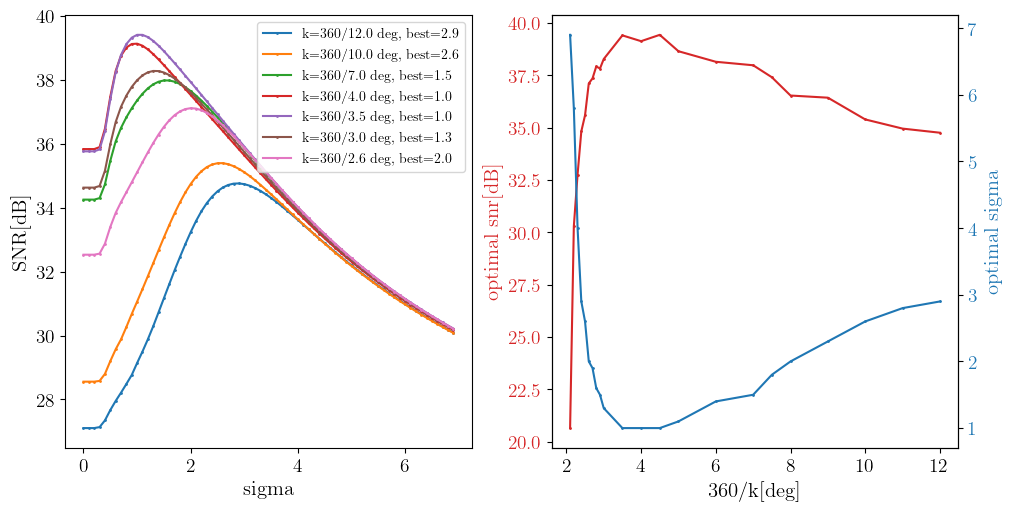

In [6]:
fig, ax1 = plt.subplots(1,2, figsize=(10, 5), layout="constrained")

for i in range(len(k_values2)):
    ax1[0].plot(using_sigmas, all_snrs_phase_1[i], "o-", markersize=1, label="k=360/{} deg, best={:.1f}".format(360/k_values2[i], using_sigmas[np.argmax(all_snrs_phase_1[i])]))

ax1[0].set_xlabel("sigma")
ax1[0].set_ylabel("SNR[dB]")

k_360 = np.zeros(len(using_k))
optimum_snr_phase = np.zeros(len(using_k))
optimum_sigma_phase = np.zeros(len(using_k))

for i in range(len(using_k)):
    optimum_snr_phase[i] = np.max(all_snrs_phase[i])
    optimum_sigma_phase[i] = using_sigmas[np.argmax(all_snrs_phase[i])]
    k_360[i] = 360/using_k[i]

color = 'tab:red'
ax1[1].set_xlabel("360/k[deg]")
ax1[1].set_ylabel('optimal snr[dB]', color=color)
ax1[1].plot(k_360, optimum_snr_phase, "o-", markersize=1, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)

ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('optimal sigma', color=color)  # we already handled the x-label with ax1
ax2.plot(k_360, optimum_sigma_phase, "o-", markersize=1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

if save_figs:
    fig.savefig("figures/CVPRfigures/optimal_prefilter_k.pdf", bbox_inches = 'tight')

ax1[0].legend(loc='upper right', fontsize=10)
if save_figs:
    fig.savefig("figures/CVPRfigures/optimal_prefilter_k_legend.pdf", bbox_inches = 'tight')


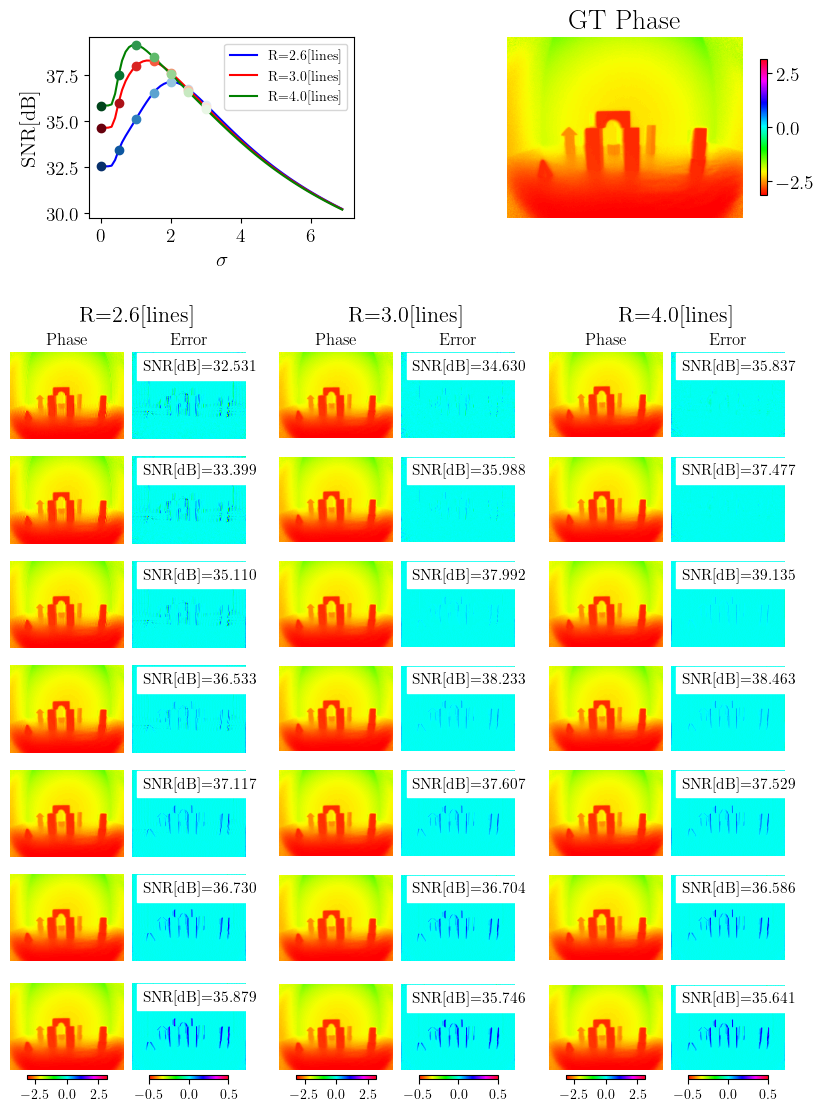

In [7]:
rows = 7
cols = 6
colors_1 = plt.cm.Blues_r(np.linspace(0,0.9,rows))
colors_2 = plt.cm.Reds_r(np.linspace(0,0.9,rows))
colors_3 = plt.cm.Greens_r(np.linspace(0,0.9,rows))


fig = plt.figure(layout='constrained', figsize=(8, 11))
subfig = fig.subfigures(2,1, height_ratios=[2, 6], hspace=0.05)

row_gts = subfig[0].subplots(1,2)
row_sigmas = subfig[1].subfigures(1, 3, wspace=0.03)

############ gt phase ############
ax = row_gts[1]
ax.set_title("GT Phase")
im = ax.imshow(phase_rw, cmap='hsv', vmin=-pi, vmax=pi)
fig.colorbar(im, ax=ax, shrink=0.75)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )

############ all sigmas ############
ax = row_gts[0]
ax.plot(using_sigmas, all_snrs_phase_1[-1], linewidth=1.5, label="R=2.6[lines]", color='b')
ax.plot(using_sigmas, all_snrs_phase_1[-2], linewidth=1.5, label="R=3.0[lines]", color='r')
ax.plot(using_sigmas, all_snrs_phase_1[-4], linewidth=1.5, label="R=4.0[lines]", color='g')
ax.set_aspect(1/1.9, adjustable='box', anchor='C')

# formatting properties
ax.set_xlabel("$\sigma$")
ax.set_ylabel("SNR[dB]")
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.legend()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# the varying sigmas
indices = np.arange(0, 35, 5)

ax1 = row_sigmas[0].subplots(rows, 2)
row_sigmas[0].suptitle("R=2.6[lines]", fontsize=16)
ax2 = row_sigmas[1].subplots(rows, 2)
row_sigmas[1].suptitle("R=3.0[lines]", fontsize=16)
ax3 = row_sigmas[2].subplots(rows, 2)
row_sigmas[2].suptitle("R=4.0[lines]", fontsize=16)

ax1[0,0].set_title("Phase", fontsize=12)
ax1[0,1].set_title("Error", fontsize=12)
ax2[0,0].set_title("Phase", fontsize=12)
ax2[0,1].set_title("Error", fontsize=12)
ax3[0,0].set_title("Phase", fontsize=12)
ax3[0,1].set_title("Error", fontsize=12)

for r in range(0,rows):
    indx = indices[r]

    # make the gradient scatters on the snr plot    
    ax.scatter(using_sigmas[indx], all_snrs_phase_1[-1][indx], color=colors_1[r], zorder=10)
    ax.scatter(using_sigmas[indx], all_snrs_phase_1[-2][indx], color=colors_2[r], zorder=10)
    ax.scatter(using_sigmas[indx], all_snrs_phase_1[-4][indx], color=colors_3[r], zorder=10)

    # plot the reconstructed phases
    im1 = ax1[r,0].imshow(recon_phases_k[-1][indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax1[r,0].set_axis_off()

    im2 = ax2[r,0].imshow(recon_phases_k[-2][indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax2[r,0].set_axis_off()

    im3 = ax3[r,0].imshow(recon_phases_k[-4][indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax3[r,0].set_axis_off()

    # plot the errors
    im1_err = ax1[r,1].imshow(diff_phases_k[-1][indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax1[r,1].annotate("SNR[dB]={:.3f}".format(all_snrs_phase_1[-1][indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax1[r,1].set_axis_off()

    im2_err = ax2[r,1].imshow(diff_phases_k[-2][indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax2[r,1].annotate("SNR[dB]={:.3f}".format(all_snrs_phase_1[-2][indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax2[r,1].set_axis_off()

    im3_err = ax3[r,1].imshow(diff_phases_k[-4][indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax3[r,1].annotate("SNR[dB]={:.3f}".format(all_snrs_phase_1[-4][indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax3[r,1].set_axis_off()
    
    if r == rows-1:
        cbar1 = row_sigmas[0].colorbar(im1, ax=ax1[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar2 = row_sigmas[0].colorbar(im1_err, ax=ax1[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar3 = row_sigmas[0].colorbar(im2, ax=ax2[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar4 = row_sigmas[0].colorbar(im2_err, ax=ax2[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar5 = row_sigmas[0].colorbar(im3, ax=ax3[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar6 = row_sigmas[0].colorbar(im3_err, ax=ax3[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        
        cbar1.ax.tick_params(labelsize=10)
        cbar2.ax.tick_params(labelsize=10)
        cbar3.ax.tick_params(labelsize=10)
        cbar4.ax.tick_params(labelsize=10)
        cbar5.ax.tick_params(labelsize=10)
        cbar6.ax.tick_params(labelsize=10)

plt.show()

save_figs=True
if save_figs:
    fig.savefig("figures/CVPRfigures/varying_sigmas_k_1.pdf", bbox_inches = 'tight')

[ 0  5 10 15 20 25 30]


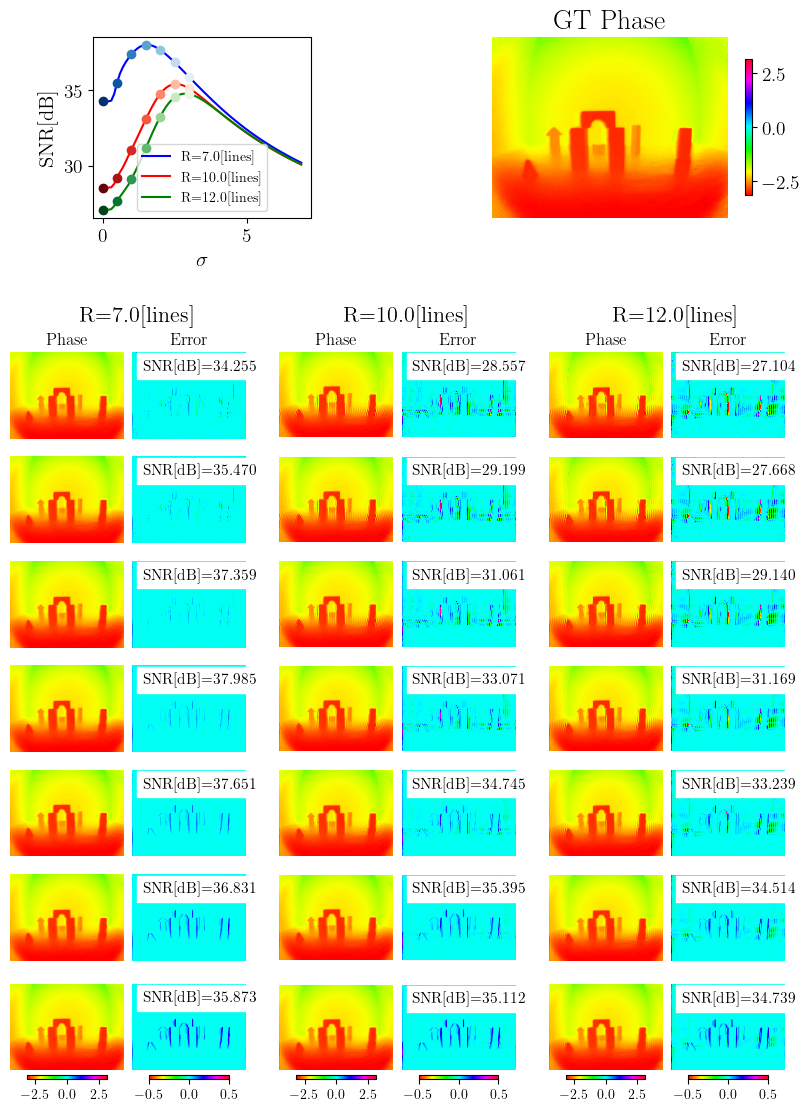

In [8]:
rows = 7
cols = 6
colors_1 = plt.cm.Blues_r(np.linspace(0,0.9,rows))
colors_2 = plt.cm.Reds_r(np.linspace(0,0.9,rows))
colors_3 = plt.cm.Greens_r(np.linspace(0,0.9,rows))


fig = plt.figure(layout='constrained', figsize=(8, 11))
# fig.suptitle("1D vs. 2D prefiltering kernel phase reconstructions with varying $\sigma$\nk=90$^{\circ}$")
subfig = fig.subfigures(2,1, height_ratios=[2, 6], hspace=0.05)

row_gts = subfig[0].subplots(1,2)
row_sigmas = subfig[1].subfigures(1, 3, wspace=0.03)

############ gt phase ############
ax = row_gts[1]
ax.set_title("GT Phase")
im = ax.imshow(phase_rw, cmap='hsv', vmin=-pi, vmax=pi)
fig.colorbar(im, ax=ax, shrink=0.75)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
ax.tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                labelbottom=False, # labels along the bottom edge are off
                labelleft=False
            )

############ all sigmas ############
ax = row_gts[0]
ax.plot(using_sigmas, all_snrs_phase_1[2], linewidth=1.5, label="R=7.0[lines]", color='b')
ax.plot(using_sigmas, all_snrs_phase_1[1], linewidth=1.5, label="R=10.0[lines]", color='r')
ax.plot(using_sigmas, all_snrs_phase_1[0], linewidth=1.5, label="R=12.0[lines]", color='g')
ax.set_aspect(1/1.9, adjustable='box', anchor='C')

# formatting properties
ax.set_xlabel("$\sigma$")
ax.set_ylabel("SNR[dB]")
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.legend()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())


# the varying sigmas
indices = np.arange(0, 35, 5)
print(indices)

ax1 = row_sigmas[0].subplots(rows, 2)
row_sigmas[0].suptitle("R=7.0[lines]", fontsize=16)
ax2 = row_sigmas[1].subplots(rows, 2)
row_sigmas[1].suptitle("R=10.0[lines]", fontsize=16)
ax3 = row_sigmas[2].subplots(rows, 2)
row_sigmas[2].suptitle("R=12.0[lines]", fontsize=16)

ax1[0,0].set_title("Phase", fontsize=12)
ax1[0,1].set_title("Error", fontsize=12)
ax2[0,0].set_title("Phase", fontsize=12)
ax2[0,1].set_title("Error", fontsize=12)
ax3[0,0].set_title("Phase", fontsize=12)
ax3[0,1].set_title("Error", fontsize=12)

for r in range(0,rows):
    indx = indices[r]

    # make the gradient scatters on the snr plot    
    ax.scatter(using_sigmas[indx], all_snrs_phase_1[2][indx], color=colors_1[r], zorder=10)
    ax.scatter(using_sigmas[indx], all_snrs_phase_1[1][indx], color=colors_2[r], zorder=10)
    ax.scatter(using_sigmas[indx], all_snrs_phase_1[0][indx], color=colors_3[r], zorder=10)

    # plot the reconstructed phases
    im1 = ax1[r,0].imshow(recon_phases_k[2][indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax1[r,0].set_axis_off()

    im2 = ax2[r,0].imshow(recon_phases_k[1][indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax2[r,0].set_axis_off()

    im3 = ax3[r,0].imshow(recon_phases_k[0][indx], cmap='hsv', vmin=-pi, vmax=pi)
    ax3[r,0].set_axis_off()

    # plot the errors
    im1_err = ax1[r,1].imshow(diff_phases_k[2][indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax1[r,1].annotate("SNR[dB]={:.3f}".format(all_snrs_phase_1[2][indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax1[r,1].set_axis_off()

    im2_err = ax2[r,1].imshow(diff_phases_k[1][indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax2[r,1].annotate("SNR[dB]={:.3f}".format(all_snrs_phase_1[1][indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax2[r,1].set_axis_off()

    im3_err = ax3[r,1].imshow(diff_phases_k[0][indx], cmap='hsv', vmin=-0.5, vmax=0.5)
    ax3[r,1].annotate("SNR[dB]={:.3f}".format(all_snrs_phase_1[0][indx]), (60,100), fontsize=11, backgroundcolor='w')
    ax3[r,1].set_axis_off()
    
    if r == rows-1:
        cbar1 = row_sigmas[0].colorbar(im1, ax=ax1[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar2 = row_sigmas[0].colorbar(im1_err, ax=ax1[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar3 = row_sigmas[0].colorbar(im2, ax=ax2[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar4 = row_sigmas[0].colorbar(im2_err, ax=ax2[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        cbar5 = row_sigmas[0].colorbar(im3, ax=ax3[r,0], orientation='horizontal', location='bottom', shrink=0.7)
        cbar6 = row_sigmas[0].colorbar(im3_err, ax=ax3[r,1], orientation='horizontal', location='bottom', shrink=0.7)
        
        cbar1.ax.tick_params(labelsize=10)
        cbar2.ax.tick_params(labelsize=10)
        cbar3.ax.tick_params(labelsize=10)
        cbar4.ax.tick_params(labelsize=10)
        cbar5.ax.tick_params(labelsize=10)
        cbar6.ax.tick_params(labelsize=10)

plt.show()

if save_figs:
    fig.savefig("figures/CVPRfigures/varying_sigmas_k_2.pdf", bbox_inches = 'tight')